In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
folder_path = '../data/CIC-IDS-2017-raw'
csv_files = [f for f in os.listdir(folder_path)]

df_list = []
for file in csv_files:
	file_path = os.path.join(folder_path, file)
	dfs = pd.read_csv(file_path, low_memory=False)
	df_list.append(dfs)

df = pd.concat(df_list, ignore_index=True)

df.to_csv('../data/CIC-IDS-2017.csv', index=False)
print('The datasets have been merged')


The datasets have been merged


In [3]:
df = pd.read_csv('../data/CIC-IDS-2017.csv')

numeric_columns = df.select_dtypes(include=[np.number])
columns_with_inf = [col for col in numeric_columns.columns if np.isinf(df[col].values).any()]

print("Columns containing NaN:", df.columns[df.isnull().any()].tolist())
print("Columns containing the inf value:", columns_with_inf)

constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Columns with 0 variance:", constant_cols)

null_counts = df.isnull().sum()
print(f'There are {null_counts.sum()} null entries in the dataset')
df.dropna(axis=1, how='any', inplace=True)

numeric_columns = numeric_columns.loc[:, ~np.isinf(numeric_columns.values).any(axis=0)]
numeric_columns = numeric_columns.loc[:, numeric_columns.nunique() > 1]

non_numeric_cols = df.select_dtypes(exclude=[np.number])
df = pd.concat([non_numeric_cols, numeric_columns], axis=1)

duplicate_counts = df.duplicated().sum()
print(f'There are {duplicate_counts.sum()} duplicate entries in the dataset')

df.drop_duplicates(inplace=True)

print(f'Size of the dataframe: {df.shape}')

df.rename(columns={' Label': 'Label'}, inplace=True)
print(f'Target column value count:\n\n{df["Label"].value_counts()}')


Columns containing NaN: ['Flow Bytes/s']
Columns containing the inf value: ['Flow Bytes/s', ' Flow Packets/s']
Columns with 0 variance: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
There are 1358 null entries in the dataset
There are 308393 duplicate entries in the dataset
Size of the dataframe: (2522350, 69)
Target column value count:

Label
BENIGN                        2096472
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection     

Label
0.0    2096472
1.0     425878
Name: count, dtype: int64


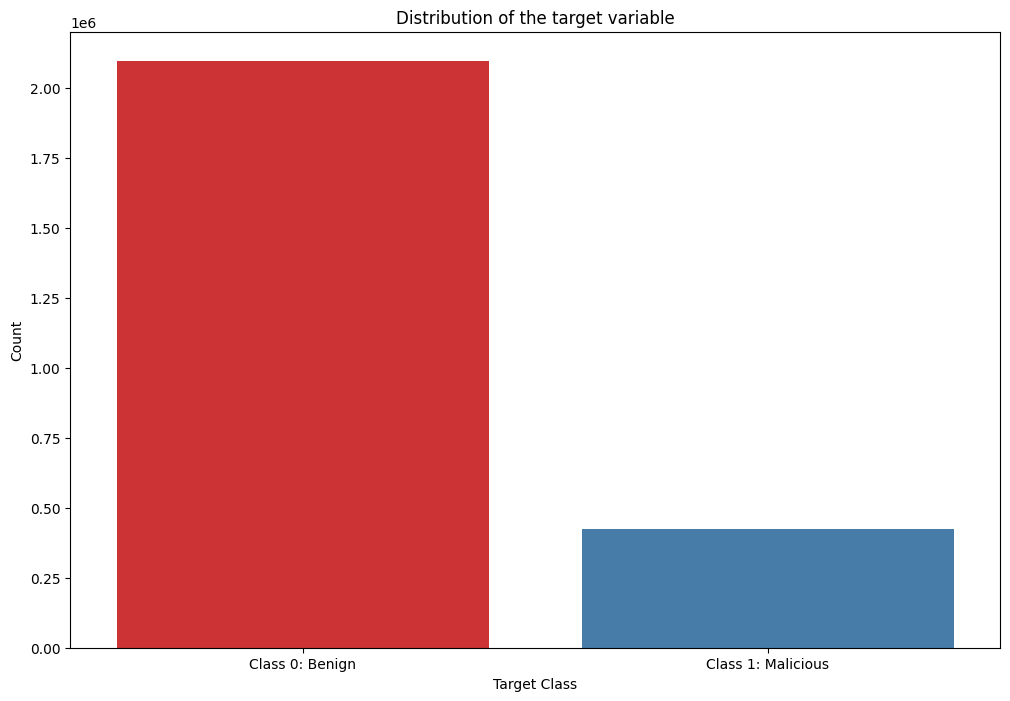

Benign ratio: 83.12%
Malicious ratio: 16.88%


In [4]:
X = df.drop('Label', axis=1)
y = df['Label']
y = y.map({'BENIGN': 0}).fillna(1)

print(y.value_counts())

plt.figure(figsize=(12, 8))
sns.countplot(x=y, palette='Set1')
plt.title('Distribution of the target variable')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0: Benign', 'Class 1: Malicious'])
plt.show()

class_ratios = y.value_counts() / len(y)

print(f'Benign ratio: {class_ratios[0]*100:.2f}%')
print(f'Malicious ratio: {class_ratios[1]*100:.2f}%')

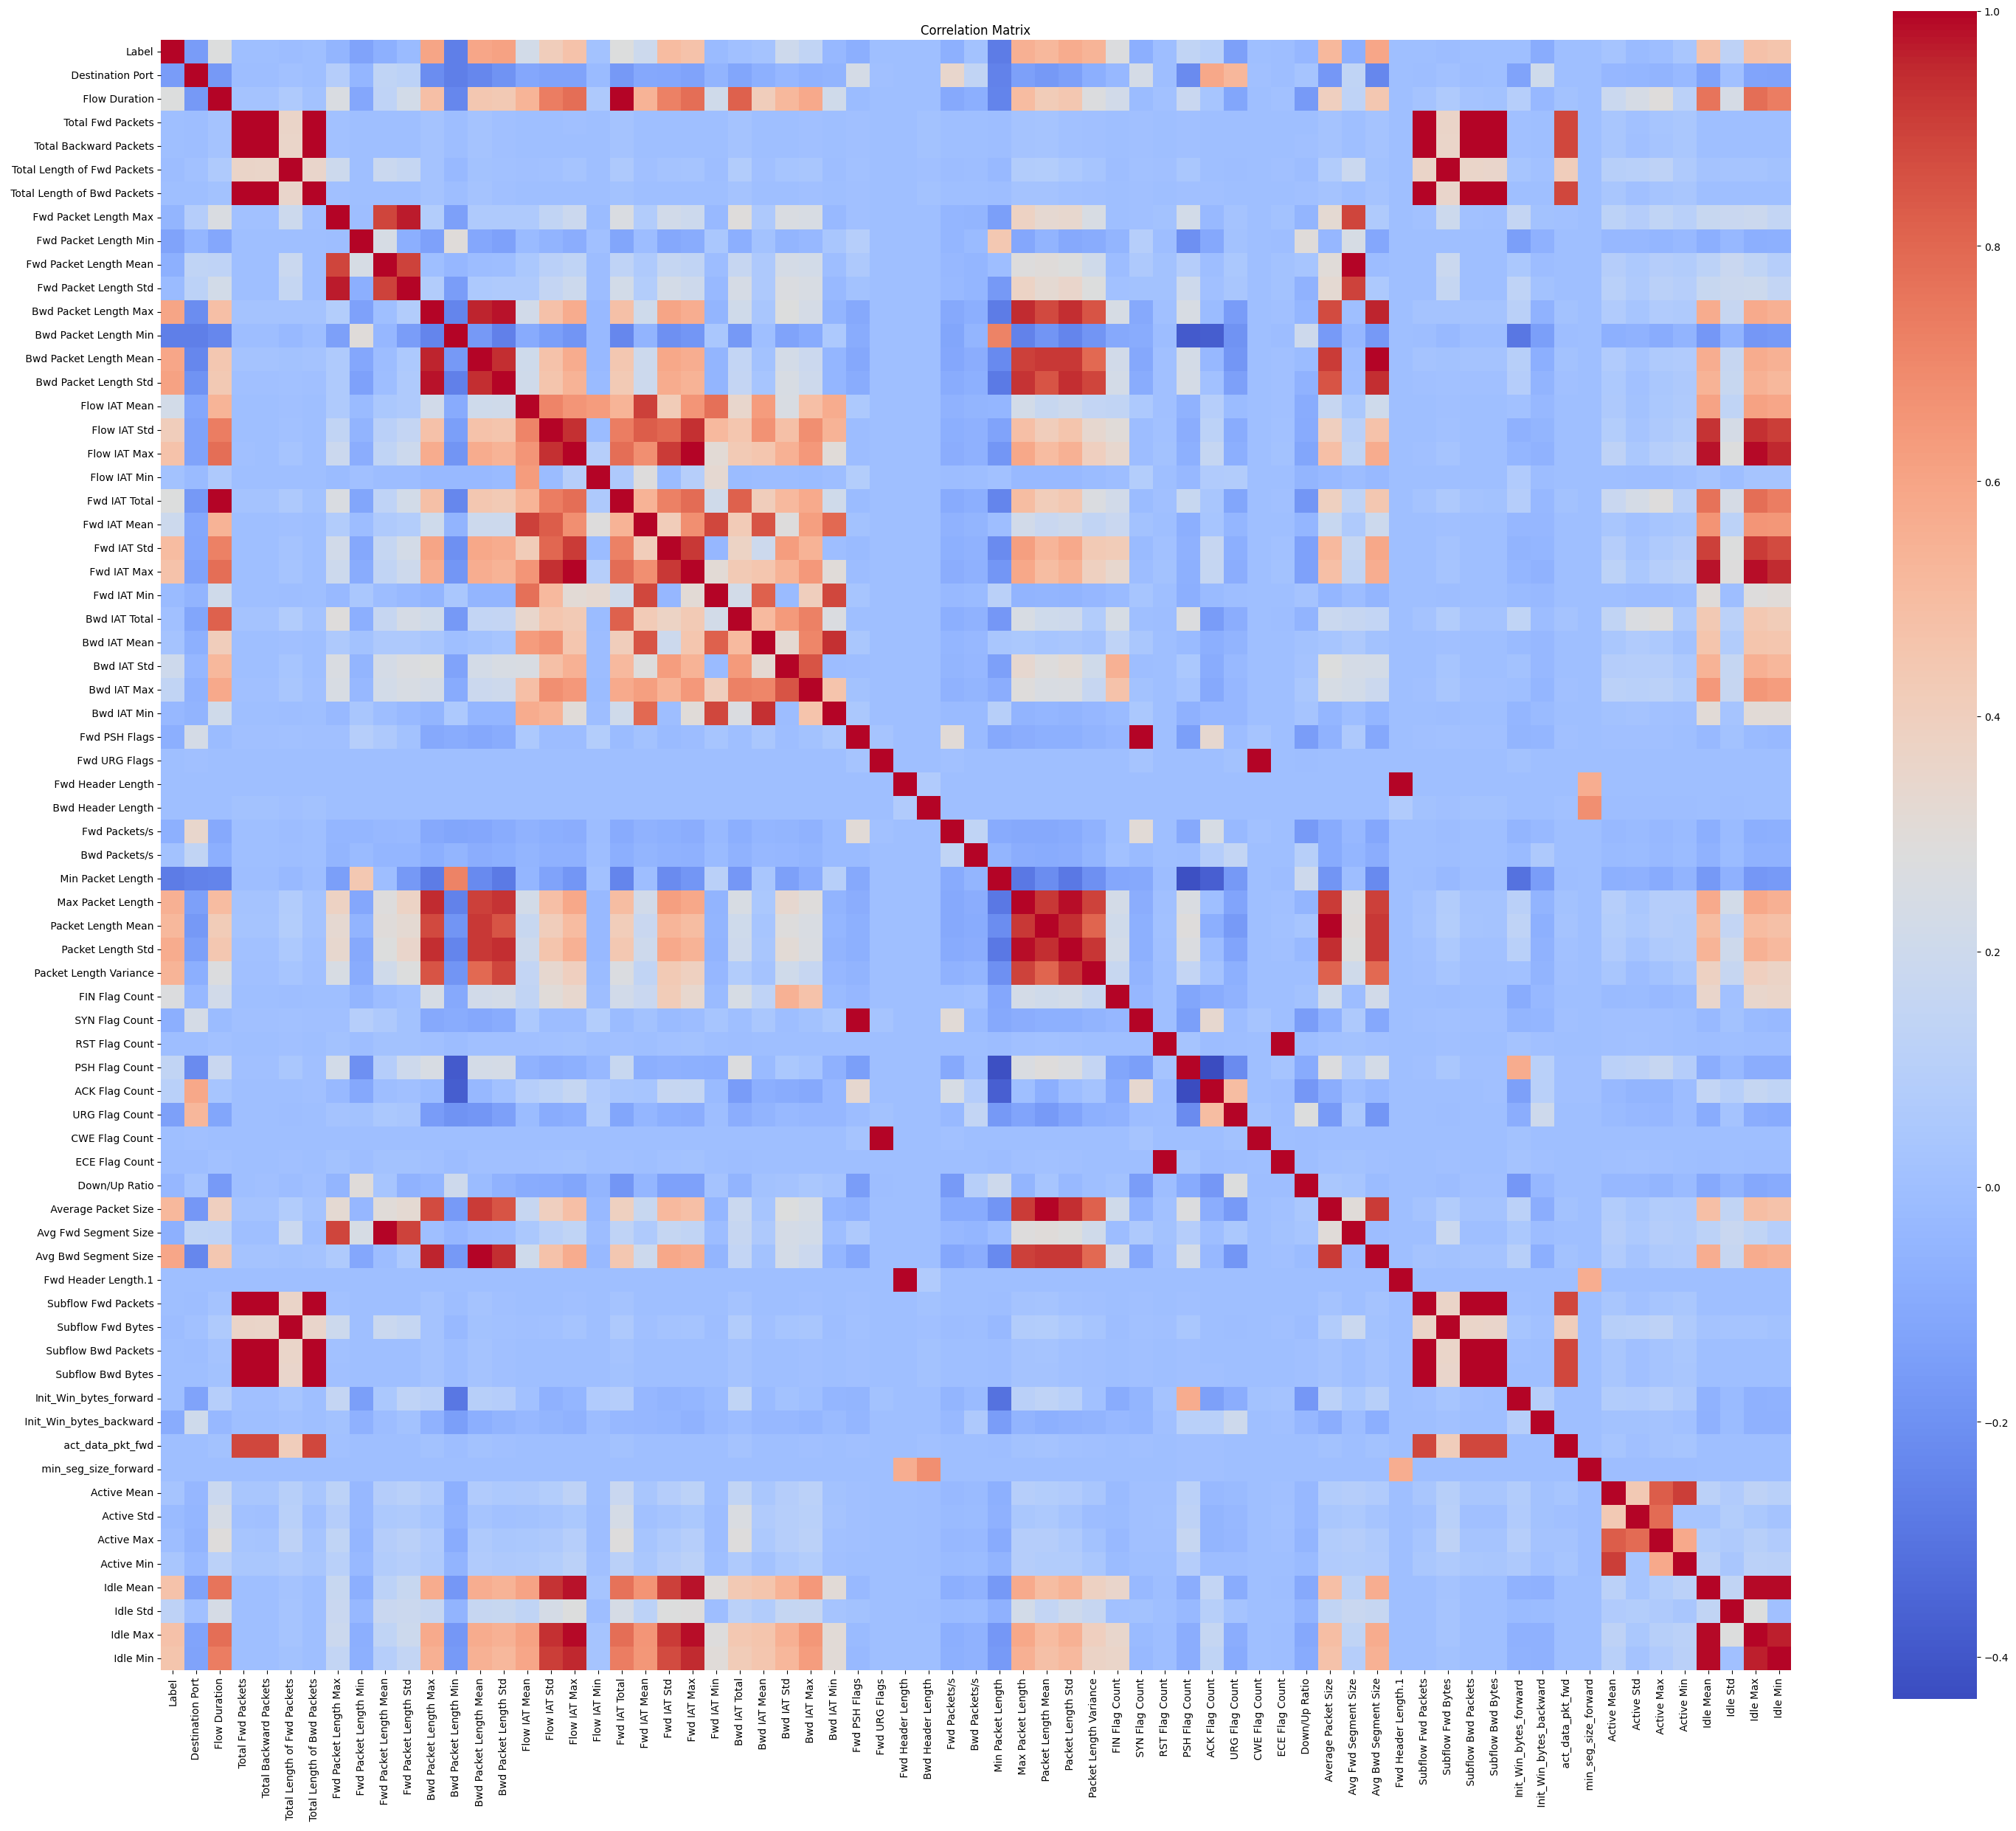

In [5]:
df['Label'] = df['Label'].map({'BENIGN': 0}).fillna(1)

plt.figure(figsize=(30, 25))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [6]:
scaler = StandardScaler()

X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)

{'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cholesky'}
[[409255   9790]
 [ 11720  73705]]


<Axes: >

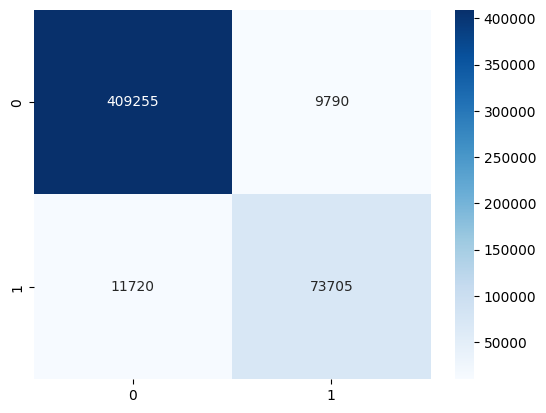

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

params = {
	'penalty': ['l2'],
	'solver': ['lbfgs', 'newton-cholesky', 'saga'],
	'C': [0.1, 1],
	'max_iter': [10]
}

model = GridSearchCV(LogisticRegression(random_state=42), params, refit = True, cv=5)

model.fit(X_train, y_train)
lr_cv_scores = model.cv_results_['mean_test_score']

print(model.best_params_)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')

In [8]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

z = 1.96
n = len(y_test)

conf_interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
lower_bound = accuracy - conf_interval
upper_bound = accuracy + conf_interval

print(f"Logistic regression accuracy: {accuracy:.4f}")
print(f"Condifence interval - 95% confidence level: [{lower_bound:.4f}, {upper_bound:.4f}]")

Logistic regression accuracy: 0.9574
Condifence interval - 95% confidence level: [0.9568, 0.9579]


{'C': 1.0, 'loss': 'squared_hinge', 'max_iter': 20, 'penalty': 'l2'}
[[408460  10585]
 [ 14936  70489]]


<Axes: >

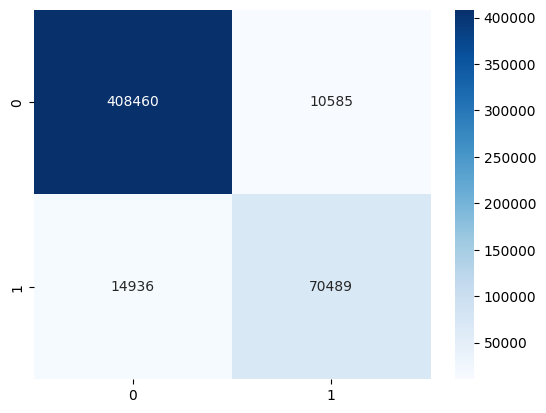

In [ ]:
from sklearn.svm import LinearSVC

params = {
	'penalty': ['l2'],
	'loss': ['hinge', 'squared_hinge'],
    'C': [1.0],
    'max_iter': [20]
}

model = GridSearchCV(LinearSVC(random_state=42), params, refit = True, cv=5)

model.fit(X_train, y_train)
svm_cv_scores = model.cv_results_['mean_test_score']

print(model.best_params_)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')

In [10]:
accuracy = accuracy_score(y_test, y_pred)

z = 1.96
n = len(y_test)

conf_interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
lower_bound = accuracy - conf_interval
upper_bound = accuracy + conf_interval

print(f"SVM accuracy: {accuracy:.4f}")
print(f"Condifence interval - 95% confidence level: [{lower_bound:.4f}, {upper_bound:.4f}]")

SVM accuracy: 0.9494
Condifence interval - 95% confidence level: [0.9488, 0.9500]


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64)


class BinaryClassifier(nn.Module):
	def __init__(self, input_dim):
		super(BinaryClassifier, self).__init__()
		
		self.net = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.BatchNorm1d(128),
			nn.Dropout(0.3),

			nn.Linear(128, 64),
			nn.ReLU(),
			nn.BatchNorm1d(64),
			nn.Dropout(0.3),

			nn.Linear(64, 32),
			nn.ReLU(),
			nn.BatchNorm1d(32),
			nn.Dropout(0.2),

			nn.Linear(32, 1),
			nn.Sigmoid()
		)

	def forward(self, x):
		return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

patience = 5
best_loss = float('inf')
counter = 0
num_epochs = 20


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
	model.train()
	running_loss, correct, total = 0.0, 0, 0
	for X_batch, y_batch in train_loader:
		X_batch, y_batch = X_batch.to(device), y_batch.to(device)

		optimizer.zero_grad()
		outputs = model(X_batch)
		loss = criterion(outputs, y_batch)
		loss.backward()
		optimizer.step()

		running_loss += loss.item() * X_batch.size(0)
		preds = (outputs > 0.5).float()
		correct += (preds == y_batch).sum().item()
		total += y_batch.size(0)

	train_loss = running_loss / total
	train_acc = correct / total

	model.eval()
	val_loss, val_correct, val_total = 0.0, 0, 0
	with torch.no_grad():
		for X_batch, y_batch in val_loader:
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)

			outputs = model(X_batch)
			loss = criterion(outputs, y_batch)
			val_loss += loss.item() * X_batch.size(0)
			preds = (outputs > 0.5).float()
			val_correct += (preds == y_batch).sum().item()
			val_total += y_batch.size(0)

	val_loss /= val_total
	val_acc = val_correct / val_total

	train_losses.append(train_loss)
	val_losses.append(val_loss)
	train_accuracies.append(train_acc)
	val_accuracies.append(val_acc)

	print(f"Epoch {epoch+1}/{num_epochs} - "
		  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - "
		  f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

	if val_loss < best_loss:
		best_loss = val_loss
		best_model = model.state_dict()
		torch.save(best_model, "best_model.pth")
		counter = 0
	else:
		counter += 1
		if counter >= patience:
			print("Early stopping triggered.")
			break


model.load_state_dict(best_model)

model.eval()

with torch.no_grad():
	y_pred = model(X_test_tensor.to(device)).cpu().numpy()
	y_pred_label = (y_pred > 0.5).astype(int)

Epoch 1/20 - Train Loss: 0.0627, Val Loss: 0.0427 - Train Acc: 0.9724, Val Acc: 0.9800
Epoch 2/20 - Train Loss: 0.0489, Val Loss: 0.0489 - Train Acc: 0.9780, Val Acc: 0.9814
Epoch 3/20 - Train Loss: 0.0456, Val Loss: 0.0401 - Train Acc: 0.9796, Val Acc: 0.9811
Epoch 4/20 - Train Loss: 0.0434, Val Loss: 0.0516 - Train Acc: 0.9808, Val Acc: 0.9782
Epoch 5/20 - Train Loss: 0.0418, Val Loss: 0.0365 - Train Acc: 0.9815, Val Acc: 0.9842
Epoch 6/20 - Train Loss: 0.0402, Val Loss: 0.0401 - Train Acc: 0.9827, Val Acc: 0.9837
Epoch 7/20 - Train Loss: 0.0412, Val Loss: 0.0321 - Train Acc: 0.9818, Val Acc: 0.9874
Epoch 8/20 - Train Loss: 0.0398, Val Loss: 0.0312 - Train Acc: 0.9827, Val Acc: 0.9869
Epoch 9/20 - Train Loss: 0.0393, Val Loss: 0.0382 - Train Acc: 0.9830, Val Acc: 0.9870
Epoch 10/20 - Train Loss: 0.0377, Val Loss: 0.0391 - Train Acc: 0.9841, Val Acc: 0.9819
Epoch 11/20 - Train Loss: 0.0384, Val Loss: 0.0318 - Train Acc: 0.9832, Val Acc: 0.9860
Epoch 12/20 - Train Loss: 0.0377, Val Los

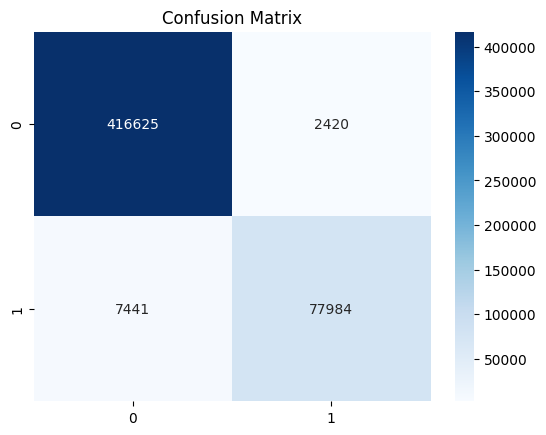

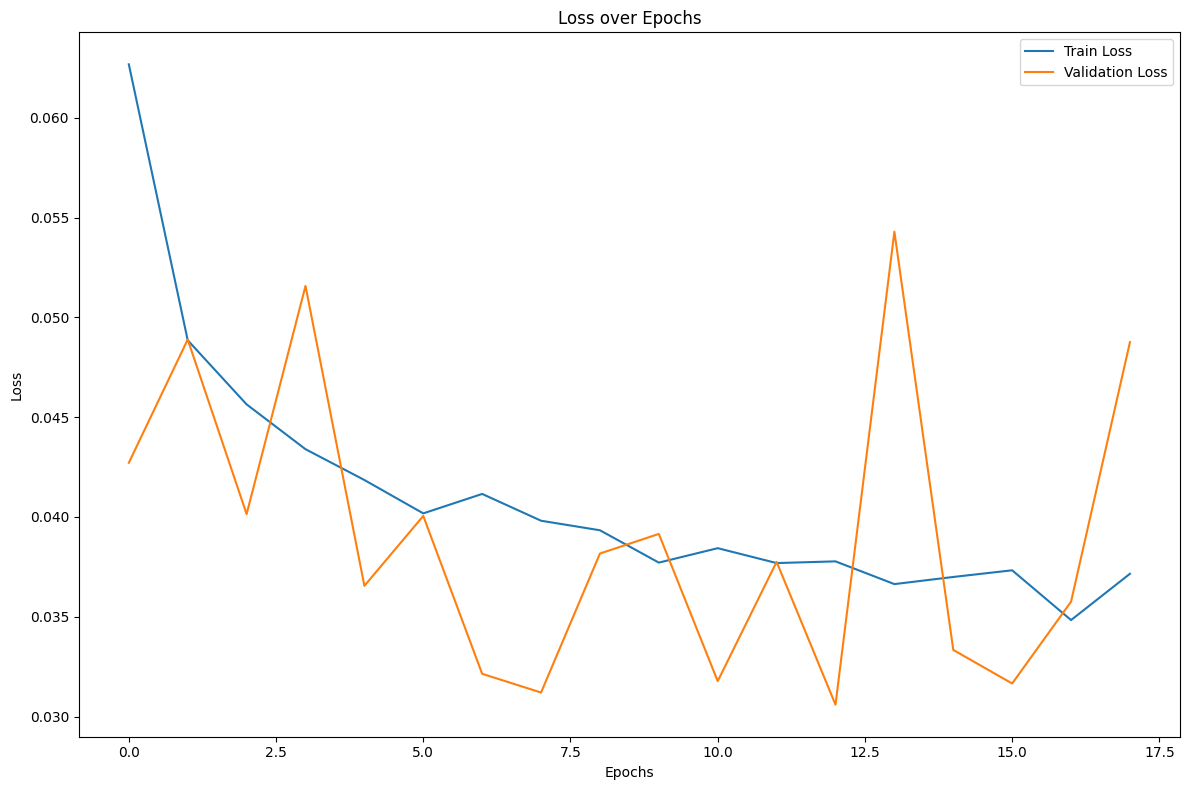

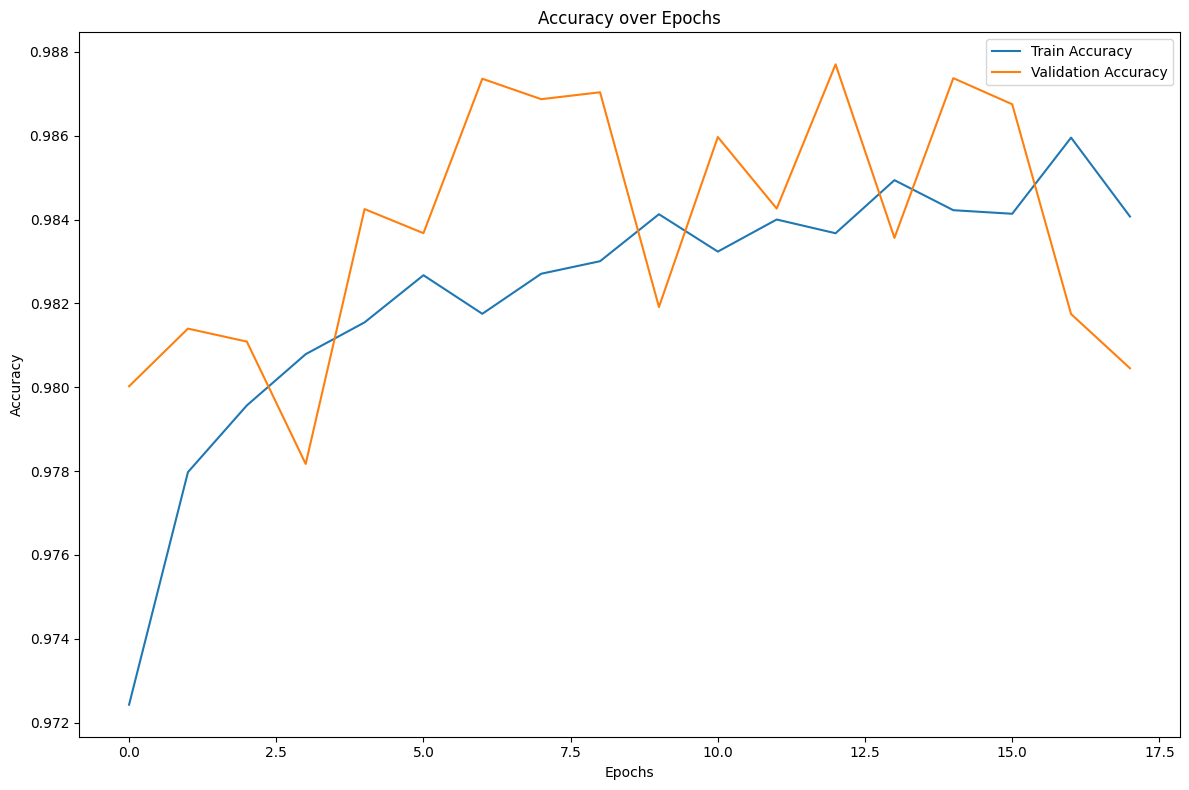

In [12]:
cm = confusion_matrix(y_test, y_pred_label)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
accuracy = accuracy_score(y_test, y_pred_label)

z = 1.96
n = len(y_test)

conf_interval = z * np.sqrt((accuracy * (1 - accuracy)) / n)
lower_bound = accuracy - conf_interval
upper_bound = accuracy + conf_interval

print(f"MLP accuracy: {accuracy:.4f}")
print(f"Condifence interval - 95% confidence level: [{lower_bound:.4f}, {upper_bound:.4f}]")

MLP accuracy: 0.9805
Condifence interval - 95% confidence level: [0.9801, 0.9808]
